In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import Image
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV 
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,\
 classification_report
from sklearn.tree import DecisionTreeClassifier
import graphviz
import numpy as np
import pandas as pd
import pydotplus
import scipy.stats as stats
import timeit
from sklearn.utils import column_or_1d 
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_excel("Telecom.xlsx")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data exploration & visualization

In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


We can see that there are a total of 7043 observers.

The % distribution of Gender is: 
Male      50.0
Female    50.0
Name: gender, dtype: float64


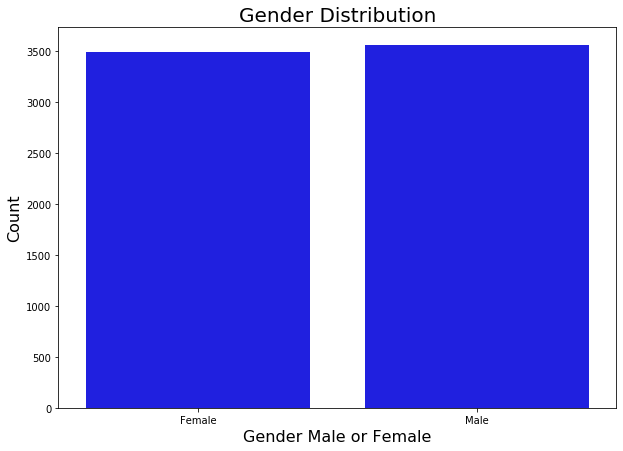

Male      3555
Female    3488
Name: gender, dtype: int64

In [4]:
# Gender 

print("The % distribution of Gender is: ")
print(round(df['gender'].value_counts(normalize=True),2)*100)

plt.figure(figsize=(10,7))

g = sns.countplot(df["gender"], color='blue')
g.set_title("Gender Distribution", fontsize=20)
g.set_ylabel('Count', fontsize=16)
g.set_xlabel('Gender Male or Female', fontsize=16)

plt.show()

df['gender'].value_counts()

We can see that 50% of customers are male and 50% are female. This means this dataset is a balanced data set.

The % distribution of Churn is: 
No     73.0
Yes    27.0
Name: Churn, dtype: float64


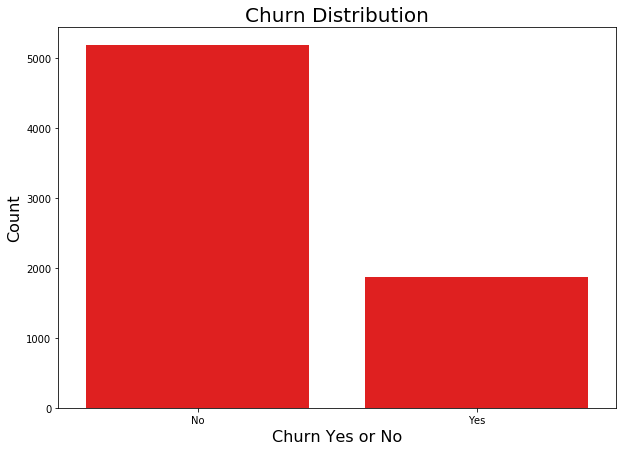

No     5174
Yes    1869
Name: Churn, dtype: int64

In [5]:
# Churn 

print("The % distribution of Churn is: ")
print(round(df['Churn'].value_counts(normalize=True),2)*100)

plt.figure(figsize=(10,7))

g = sns.countplot(df["Churn"], color='red')
g.set_title("Churn Distribution", fontsize=20)
g.set_ylabel('Count', fontsize=16)
g.set_xlabel('Churn Yes or No', fontsize=16)

plt.show()
df['Churn'].value_counts()

We can see that 73% of customers churn and 27% do not churn.

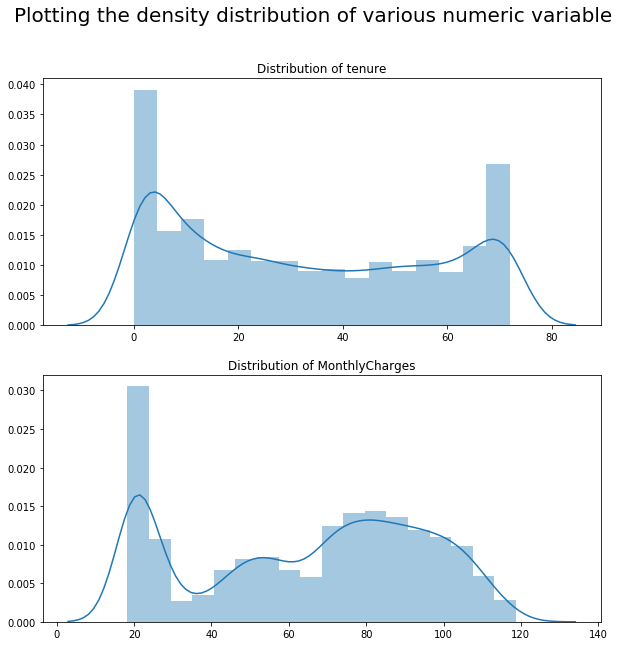

In [6]:
def draw_subplots(var_Name,tittle_Name,nrow=1,ncol=1,idx=1,fz=10): # Define a common module for drawing subplots.
    ax = plt.subplot(nrow,ncol,idx)                   #  idx - position of subplot in the main plotting window
    ax.set_title('Distribution of '+var_Name)         #  fz - the font size of Tittle in the main plotting window
    plt.suptitle(tittle_Name, fontsize=fz)

numeric_columns = ['tenure', 'MonthlyCharges']

fig,ax = plt.subplots(1,1, figsize=(10,10))
j=0  # reset the counter to plot 
title_Str="Plotting the density distribution of various numeric variable"

for i in numeric_columns:
    j +=1
    draw_subplots(i,title_Str,2,1,j,20) # create a 1x3 subplots for plotting distribution plots
    sns.distplot(df[i])
    plt.xlabel('')

We can get some conclusion from Density plots.First,the Tenure is not normally distribute.The distribution of data is high on both sides and low in the middle.Secondly, the MonthlyCharges is also not normally distribute.This distribution is relatively high at 20, and after 40,this part is generally in a normal distribution trend.

# Convert some categorical variables to numerical variables

In [7]:
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,No
1,5575-GNVDE,0,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.5,No
2,3668-QPYBK,0,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,0,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,1,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,Yes


In [8]:
dm_MultipleLines = pd.get_dummies(df['MultipleLines'], prefix='MultipleLines')
dm_InternetService = pd.get_dummies(df['InternetService'], prefix='InternetService')
dm_OnlineSecurity = pd.get_dummies(df['OnlineSecurity'], prefix='OnlineSecurity')
dm_OnlineBackup = pd.get_dummies(df['OnlineBackup'], prefix='OnlineBackup')
dm_DeviceProtection = pd.get_dummies(df['DeviceProtection'], prefix='DeviceProtection')
dm_TechSupport = pd.get_dummies(df['TechSupport'], prefix='TechSupport')
dm_StreamingTV = pd.get_dummies(df['StreamingTV'], prefix='StreamingTV')
dm_StreamingMovies = pd.get_dummies(df['StreamingMovies'], prefix='StreamingMovies')
dm_Contract = pd.get_dummies(df['Contract'], prefix='Contract')
dm_PaymentMethod = pd.get_dummies(df['PaymentMethod'], prefix='PaymentMethod')

In [9]:
df = pd.concat([df,dm_MultipleLines],axis = 1)
df = pd.concat([df,dm_InternetService],axis = 1)
df = pd.concat([df,dm_OnlineSecurity],axis = 1)
df = pd.concat([df,dm_OnlineBackup],axis = 1)
df = pd.concat([df,dm_DeviceProtection],axis = 1)
df = pd.concat([df,dm_TechSupport],axis = 1)
df = pd.concat([df,dm_StreamingTV],axis = 1)
df = pd.concat([df,dm_StreamingMovies],axis = 1)
df = pd.concat([df,dm_Contract],axis = 1)
df = pd.concat([df,dm_PaymentMethod],axis = 1)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,No phone service,DSL,No,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,No,DSL,Yes,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,No,DSL,Yes,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,No phone service,DSL,Yes,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,1,0,0,0,2,1,No,Fiber optic,No,...,1,0,0,1,0,0,0,0,1,0


In [10]:
df = df.drop(['customerID','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
              'TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod','TotalCharges'], 1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,29.85,No,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,56.95,No,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,1,53.85,Yes,1,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,42.30,No,0,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,1,70.70,Yes,1,...,1,0,0,1,0,0,0,0,1,0


In [11]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
Churn                                       object
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_No internet servic

# Holdout (splitting data)

In [12]:
x = df.drop(['Churn'],1)
y = df[['Churn']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

# 1.Select Kbest

In [13]:
from sklearn import linear_model, decomposition, datasets
logistic = linear_model.LogisticRegression()
kbest = SelectKBest(chi2)
pca = decomposition.PCA()
pipe = Pipeline(steps=[('kbest', kbest), ('logistic', logistic)])

n_components = [3,4,5,6,7,8]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(kbest__k=n_components,
                              logistic__C=Cs))
aaa = estimator.fit(x_train, y_train)

print(" Best_score： %.4lf" %estimator.best_score_)

print(" Best_params：", estimator.best_params_)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Speci

 Best_score： 0.7955
 Best_params： {'kbest__k': 5, 'logistic__C': 1.0}


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in

Here I got the result: the best k = 5.It means that we only keep five veriables. The next step is find out the five variables.

In [14]:
x_new = SelectKBest(score_func=chi2, k=5)
x_new.fit_transform(x_train, y_train)
print(x_new.get_support())

[False False False False  True False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False  True False
 False  True False]


Therefore, the seven variables are:

'tenure', 'MonthlyCharges', 'PaymentMethod_Electronic check', 'Contract_Two year', 'Contract_Month-to-month'    

In [15]:
X = df[['tenure','MonthlyCharges','PaymentMethod_Electronic check','Contract_Two year','Contract_Month-to-month']]
Y = df[['Churn']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

## Model 1: Decision Tree Model

### Criterion: Entropy (Information Gain)

In [16]:
start_time = timeit.default_timer()

for i in range(1,11,1):
    decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state = 0)
    decision_tree.fit(X_train,Y_train)

    dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Yes', 'No'], filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
    print('Depth: {}'.format(i))
    print('Model Performance: {:.2%}.\n'.format(cross_val_score(decision_tree, X_train, Y_train, cv=10).mean()))

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

Depth: 1
Model Performance: 73.44%.

Depth: 2
Model Performance: 75.22%.

Depth: 3
Model Performance: 78.77%.

Depth: 4
Model Performance: 79.29%.

Depth: 5
Model Performance: 78.72%.

Depth: 6
Model Performance: 78.60%.

Depth: 7
Model Performance: 78.37%.

Depth: 8
Model Performance: 77.54%.

Depth: 9
Model Performance: 76.80%.

Depth: 10
Model Performance: 76.50%.

--- Runtime: 22.323417300000003 seconds. ---


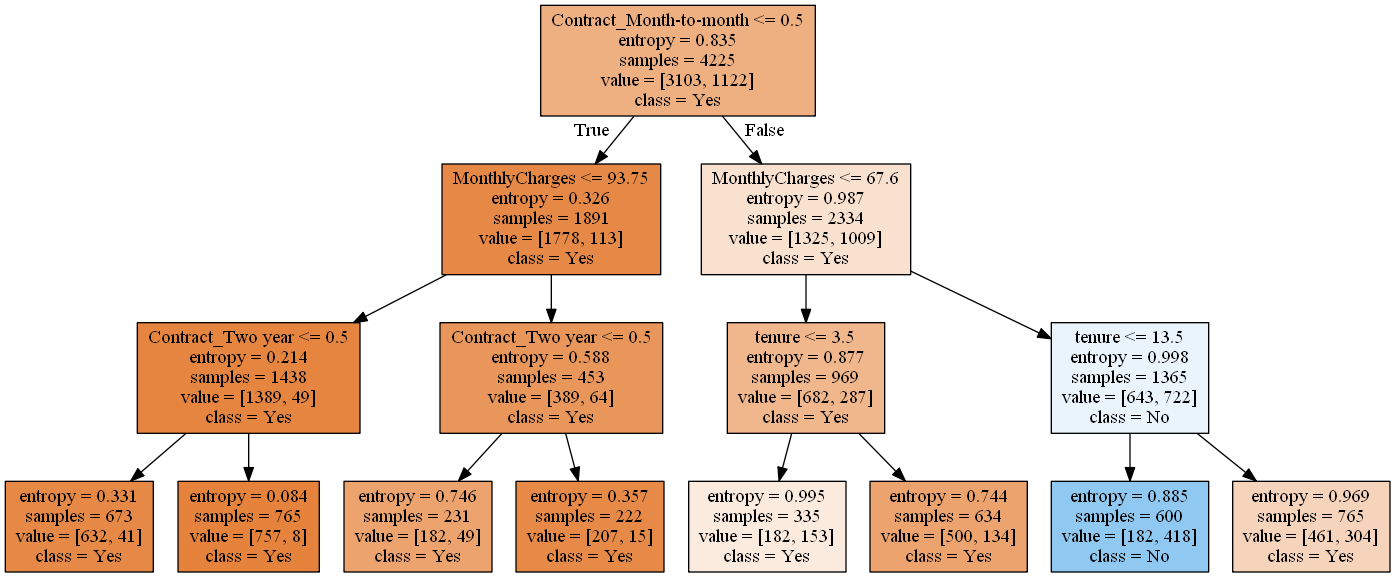

In [17]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 0)
decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Yes', 'No'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [18]:
start_time = timeit.default_timer()

decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
dtmodel=decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.1619565999999999 seconds. ---


### Cross validation

In [19]:
scores = cross_val_score(decision_tree, X_train, Y_train, cv=10)
print(scores.mean())

0.7521993632051689


### Classification_report and Confusion matrix

In [20]:
Y_pred = dtmodel.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Decision Tree Model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Decision Tree Model Classification report:
Accuracy:  0.7473385379701917
              precision    recall  f1-score   support

          No       0.80      0.85      0.82      1939
         Yes       0.61      0.52      0.56       879

    accuracy                           0.75      2818
   macro avg       0.70      0.69      0.69      2818
weighted avg       0.74      0.75      0.74      2818

Confusion matrix:
[[1649  422]
 [ 290  457]]


## Model 2: Random forest model

In [21]:
rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,feature,importance
0,MonthlyCharges,0.557561
1,tenure,0.265436
2,Contract_Month-to-month,0.107232
3,PaymentMethod_Electronic check,0.043295
4,Contract_Two year,0.026475


In [22]:
start_time = timeit.default_timer()

rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.044607899999999034 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


### Cross validation

In [23]:
scores = cross_val_score(rfc, X_train, Y_train, cv=10)
print(scores.mean())

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\

0.7642634125294452


### Classification_report and Confusion matrix

In [24]:
Y_pred = dtmodel_R.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Random forest model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Random forest model Classification report:
Accuracy:  0.9655784244144784
              precision    recall  f1-score   support

          No       0.99      0.97      0.98      2106
         Yes       0.91      0.96      0.93       712

    accuracy                           0.97      2818
   macro avg       0.95      0.96      0.96      2818
weighted avg       0.97      0.97      0.97      2818

Confusion matrix:
[[2040   31]
 [  66  681]]


## Model 3: KNN Classification 

In [25]:
neighbors = KNeighborsClassifier(n_neighbors=3)
model_neighbors = neighbors.fit(X_test, Y_test)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [26]:
start_time = timeit.default_timer()

neighbors = KNeighborsClassifier(n_neighbors=3)
model_n = neighbors.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.0059976000000006024 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


### Cross validation

In [27]:
scores = cross_val_score(neighbors, X_train, Y_train, cv=10)
print(scores.mean())

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\progra

0.7583476317798313


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


### Classification_report and Confusion matrix

In [28]:
Y_pred = model_neighbors.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("KNN Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

KNN Classification report:
Accuracy:  0.8591199432221434
              precision    recall  f1-score   support

          No       0.93      0.88      0.91      2190
         Yes       0.65      0.78      0.71       628

    accuracy                           0.86      2818
   macro avg       0.79      0.83      0.81      2818
weighted avg       0.87      0.86      0.86      2818

Confusion matrix:
[[1932  139]
 [ 258  489]]


## 4. Naive Bayes Classifier

In [29]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
start_time = timeit.default_timer()

bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.006952800000000536 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Cross validation

In [31]:
scores = cross_val_score(bayes, X_train, Y_train, cv=10)
print(scores.mean())

0.6823618105749418


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataC

### Classification_report and Confusion matrix

In [32]:
Y_pred = model_bayes.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Naive Bayes Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Naive Bayes Classification report:
Accuracy:  0.6880766501064585
              precision    recall  f1-score   support

          No       0.63      0.92      0.75      1432
         Yes       0.84      0.45      0.59      1386

    accuracy                           0.69      2818
   macro avg       0.74      0.68      0.67      2818
weighted avg       0.73      0.69      0.67      2818

Confusion matrix:
[[1312  759]
 [ 120  627]]


## 5. Logistic regression

In [33]:
logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
start_time = timeit.default_timer()

logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.009867899999996155 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Cross validation

In [35]:
scores = cross_val_score(logreg, X_train, Y_train, cv=10)
print(scores.mean())

0.7945554734273506


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

### Classification_report and Confusion matrix

In [36]:
Y_pred = model_logreg.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Logistic regression Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Logistic regression Classification report:
Accuracy:  0.7856635911994322
              precision    recall  f1-score   support

          No       0.90      0.82      0.86      2257
         Yes       0.47      0.63      0.54       561

    accuracy                           0.79      2818
   macro avg       0.69      0.73      0.70      2818
weighted avg       0.81      0.79      0.80      2818

Confusion matrix:
[[1862  209]
 [ 395  352]]


## 6. SVC

In [37]:
svc = SVC(kernel='linear')
model_svc = svc.fit(X_train, y_train)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
start_time = timeit.default_timer()

svc = SVC(kernel='linear')
model_sve = svc.fit(X_train, y_train)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Runtime: 5.8859376999999995 seconds. ---


### Cross validation

In [39]:
scores = cross_val_score(svc, X_train, Y_train, cv=10)
print(scores.mean())

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataC

0.7921813393936973


### Classification_report and Confusion matrix

In [40]:
Y_pred = model_svc.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("SVC Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

SVC Classification report:
Accuracy:  0.7888573456352023
              precision    recall  f1-score   support

          No       0.89      0.84      0.86      2192
         Yes       0.52      0.62      0.57       626

    accuracy                           0.79      2818
   macro avg       0.70      0.73      0.71      2818
weighted avg       0.80      0.79      0.80      2818

Confusion matrix:
[[1834  237]
 [ 358  389]]


# PCA

In [41]:
from sklearn import linear_model, decomposition, datasets
from sklearn.decomposition import PCA

x = df.drop(['Churn'],1)
y = df[['Churn']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

n_components = [3,4,5,6,7]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(x_train, y_train)

print(" Best_score： %.4lf" %estimator.best_score_)

print(" Best_params：", estimator.best_params_)


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Speci

 Best_score： 0.8047
 Best_params： {'logistic__C': 1.0, 'pca__n_components': 6}


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in

Here I got the result: pca__n_components = 5.It means that we now have five new features.

In [42]:
pca = PCA(n_components=5)
x_transformed = pd.DataFrame(pca.fit_transform(x))
X_train, X_test, Y_train, Y_test = train_test_split(x_transformed, y, test_size=0.4, random_state=0)
print(x_transformed)

              0          1         2         3         4
0    -44.918853 -13.562394  2.035919 -0.119331  0.817144
1     -6.381646   4.788737  1.184516  0.739046 -0.717900
2    -22.804599 -22.853649  1.027127  0.732948 -1.068087
3    -14.934173  20.987156  1.979399  1.094721  0.115015
4     -7.556088 -30.060522  0.488954 -0.885201 -0.495125
...         ...        ...       ...       ...       ...
7038  14.590449 -16.063780 -0.457287  2.057374  0.580485
7039  51.679561  19.500852 -0.531559 -0.407181  0.502925
7040 -40.893905  -4.406463  2.249094  0.094667  0.446514
7041  -3.347029 -29.808398  0.360741 -0.894058 -0.436005
7042  51.322465  13.039884 -0.704995  0.708144 -0.311900

[7043 rows x 5 columns]


## Model 1: Decision Tree Model

### Criterion: Entropy (Information Gain)

In [43]:
start_time = timeit.default_timer()

for i in range(1,11,1):
    decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state = 0)
    decision_tree.fit(X_train,Y_train)

    dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
    print('Depth: {}'.format(i))
    print('Model Performance: {:.2%}.\n'.format(cross_val_score(decision_tree, X_train, Y_train, cv=10).mean()))

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

Depth: 1
Model Performance: 73.14%.

Depth: 2
Model Performance: 78.51%.

Depth: 3
Model Performance: 78.27%.

Depth: 4
Model Performance: 77.66%.

Depth: 5
Model Performance: 78.53%.

Depth: 6
Model Performance: 79.08%.

Depth: 7
Model Performance: 78.13%.

Depth: 8
Model Performance: 78.48%.

Depth: 9
Model Performance: 77.28%.

Depth: 10
Model Performance: 77.35%.

--- Runtime: 20.644875299999995 seconds. ---


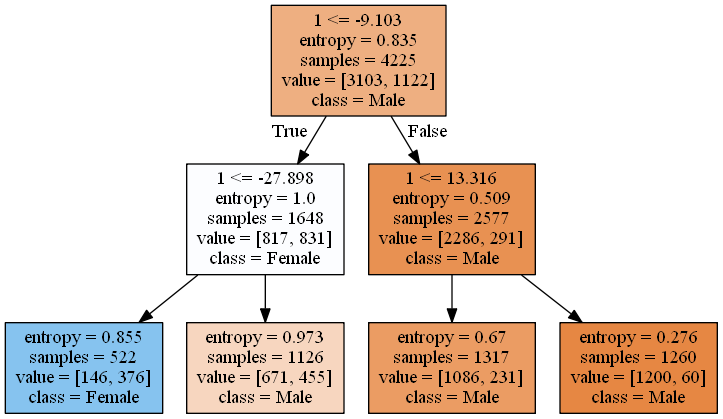

In [44]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [45]:
start_time = timeit.default_timer()

decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
dtmodel=decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.1780436000000094 seconds. ---


### Cross validation

In [46]:
scores = cross_val_score(decision_tree, X_train, Y_train, cv=10)
print(scores.mean())

0.7850863107185868


### Classification_report and Confusion matrix

In [47]:
Y_pred = dtmodel.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Decision Tree Model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Decision Tree Model Classification report:
Accuracy:  0.7895670688431512
              precision    recall  f1-score   support

          No       0.95      0.80      0.87      2474
         Yes       0.33      0.72      0.46       344

    accuracy                           0.79      2818
   macro avg       0.64      0.76      0.66      2818
weighted avg       0.88      0.79      0.82      2818

Confusion matrix:
[[1976   95]
 [ 498  249]]


## Model 2: Random forest model

In [48]:
rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,feature,importance
0,1,0.315222
1,3,0.183949
2,2,0.174628
3,0,0.165769
4,4,0.160432


In [49]:
start_time = timeit.default_timer()

rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.06883770000000311 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


### Cross validation

In [50]:
scores = cross_val_score(rfc, X_train, Y_train, cv=10)
print(scores.mean())

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\

0.7763246793247688


### Classification_report and Confusion matrix

In [51]:
Y_pred = dtmodel_R.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Random forest model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Random forest model Classification report:
Accuracy:  0.9804826117814053
              precision    recall  f1-score   support

          No       1.00      0.98      0.99      2112
         Yes       0.94      0.99      0.96       706

    accuracy                           0.98      2818
   macro avg       0.97      0.98      0.97      2818
weighted avg       0.98      0.98      0.98      2818

Confusion matrix:
[[2064    7]
 [  48  699]]


## Model 3: KNN Classification

In [52]:
neighbors = KNeighborsClassifier(n_neighbors=3)
model_neighbors = neighbors.fit(X_test, Y_test)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [53]:
start_time = timeit.default_timer()

neighbors = KNeighborsClassifier(n_neighbors=3)
model_n = neighbors.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.005606299999996622 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


### Cross validation

In [54]:
scores = cross_val_score(neighbors, X_train, Y_train, cv=10)
print(scores.mean())

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alan\appdata\local\progra

0.7578586069407529


### Classification_report and Confusion matrix

In [55]:
Y_pred = model_neighbors.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("KNN Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

KNN Classification report:
Accuracy:  0.8577004968062456
              precision    recall  f1-score   support

          No       0.93      0.88      0.91      2170
         Yes       0.67      0.77      0.71       648

    accuracy                           0.86      2818
   macro avg       0.80      0.83      0.81      2818
weighted avg       0.87      0.86      0.86      2818

Confusion matrix:
[[1920  151]
 [ 250  497]]


## 4. Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
start_time = timeit.default_timer()

bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.0056129999999967595 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Cross validation

In [58]:
scores = cross_val_score(bayes, X_train, Y_train, cv=10)
print(scores.mean())

0.7895808507255927


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataC

### Classification_report and Confusion matrix

In [59]:
Y_pred = model_bayes.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Naive Bayes Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Naive Bayes Classification report:
Accuracy:  0.7792760823278921
              precision    recall  f1-score   support

          No       0.86      0.84      0.85      2115
         Yes       0.55      0.59      0.57       703

    accuracy                           0.78      2818
   macro avg       0.71      0.72      0.71      2818
weighted avg       0.78      0.78      0.78      2818

Confusion matrix:
[[1782  289]
 [ 333  414]]


## 5. Logistic regression

In [60]:
logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
start_time = timeit.default_timer()

logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.009900200000004133 seconds. ---


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Cross validation

In [62]:
scores = cross_val_score(logreg, X_train, Y_train, cv=10)
print(scores.mean())

0.8035518228973435


c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

### Classification_report and Confusion matrix

In [63]:
Y_pred = model_logreg.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Logistic regression Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Logistic regression Classification report:
Accuracy:  0.7973740241305891
              precision    recall  f1-score   support

          No       0.90      0.84      0.87      2212
         Yes       0.52      0.65      0.58       606

    accuracy                           0.80      2818
   macro avg       0.71      0.74      0.72      2818
weighted avg       0.82      0.80      0.80      2818

Confusion matrix:
[[1856  215]
 [ 356  391]]


## 6. SVC

In [64]:
svc = SVC(kernel='linear')
model_svc = svc.fit(X_train, y_train)

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
start_time = timeit.default_timer()

svc = SVC(kernel='linear')
model_sve = svc.fit(X_train, y_train)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Runtime: 3.8759111999999902 seconds. ---


### Cross validation

In [66]:
scores = cross_val_score(svc, X_train, Y_train, cv=10)
print(scores.mean())

c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\alan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:724: DataC

0.8000017995272714


### Classification_report and Confusion matrix

In [67]:
Y_pred = model_svc.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("SVC Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

SVC Classification report:
Accuracy:  0.7938254080908446
              precision    recall  f1-score   support

          No       0.89      0.84      0.86      2208
         Yes       0.52      0.64      0.57       610

    accuracy                           0.79      2818
   macro avg       0.71      0.74      0.72      2818
weighted avg       0.81      0.79      0.80      2818

Confusion matrix:
[[1849  222]
 [ 359  388]]


# write-up analysis and conclusions

We used teo methods to process the variables: Select kbest and PCA. And we used seven models on both of them: Decesion tree model, Random forest model, KNN Classification, Naive Bayes Classifier, Logistic regression, SVC and Gradient Boosting Classifiers.

From the classification report, we can see that: Almost for all models, PCA is more accurate than the Select kbest method,since the accuracy value is larger. So PCA is more suitable for this dataset.

For Select kbest method, Random forest model has the largest accuracy value(0.83).This means that base on Select kbest method, Random forest model can classify our data sets more accurately. For time execution, SVC takes the longest time(3.11s) and Naive Bayes Classifier takes the shortest time(0.005s).

For PCA, Random forest model has the largest accuracy value(0.97).This means that base on Select kbest method, Random forest model can classify our data sets more accurately. For time execution, SVC takes the longest time(5.6s) and Naive Bayes Classifier takes the shortest time(0.004s).